# Plot TimeSeries Diagram

-> set config.yaml

-> run every cell, output diagram will be saved in folder /reports as .svg

In [1]:
%cd ..
%cd ..
#now your wor_dir is correlty set to .../{{ cookiecutter.repo_name }}

C:\Users\Tom\Desktop\MA\{{ cookiecutter.repo_name }}\notebooks
C:\Users\Tom\Desktop\MA\{{ cookiecutter.repo_name }}


'C:\\Users\\Tom\\Desktop\\MA\\{{ cookiecutter.repo_name }}'

In [10]:
#load config
from omegaconf import OmegaConf
cfg = OmegaConf.load('configs/config.yaml')

In [11]:
# %load src/preprocess/preprocess_baseclass.py
import abc, os, prefect
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split


class PreprocessingBaseClass_TimeSeries(abc.ABC):
    @abc.abstractmethod
    def __init__(self, config):
        self.config = config

    @abc.abstractmethod
    def load_data(self, file_path, file_name, file_sheet):
        csv_path = os.path.join(file_path, file_name)
        return pd.read_excel(csv_path, sheet_name=file_sheet)

    def cleaning_data(self, data, file_columns, file_columns_method, label):
        #selection useful columns
        if file_columns_method == "include":
            data = data.filter(items=file_columns, axis=1)
        elif file_columns_method == "exclude":
            data = data.drop(labels=file_columns, axis=1)
        else:
            raise ValueError("Wrong input! See config file_columns_method!")

        #delete incorrect text columns
        data = self.del_text_columns(data)

        #replace incorrect num columns
        data = self.del_num_columns(data)

        #counts number of labels
        unique, frequency = np.unique(data[label], return_counts = True)
        print("Number classes:", len(unique), "\nName classes:", *unique)
        print("Number samples of each class:", *frequency)
        return data 

    def del_text_columns(self, data): 
        #delete incorrect text columns (empty get deleted)
        #search all text columns
        old_data = len(data)
        text_vars = data.select_dtypes(include=["object"])
        
        #delete incorrect columns
        data = data.dropna(subset=text_vars.columns,how="any")
        
        #output
        count_deleted_rows = old_data - len(data)
        print("Due to missing textual information", count_deleted_rows, "rows deleted.")
        return data

    def del_num_columns(self, data): 
        #replace incorrect num columns (attention, value = 0 is NO incorrect value, but NaN)
        #calculate median/mean
        fill_mean = lambda col: col.fillna(col.mean())
        fill_median = lambda col: col.fillna(col.median())
        
        #search all numeric columns
        num_vars = data.select_dtypes(include=["number"])
        count_changed_values = num_vars.isna().sum().sum()
        
        #set median/mean value in numeric columns with fillna (see above)
        data[num_vars.columns] = data[num_vars.columns].apply(fill_median)
        
        #output
        print("Due to missing numerical data(NaN)", count_changed_values, "results replaced by median value.")
        return data

    def sklearn_normalization(self, data): 
        #normalization (d.h. values in range 0-1)
        #search all numeric columns
        num_vars = data.select_dtypes(include=["number"])
        
        #normalizer
        data[num_vars.columns] = MinMaxScaler().fit_transform(num_vars.values)
        return data

    def sklearn_standardization(self, data): 
        #here no range 0-1(!), but mean=0 and std=1, can cause problems by NN, but better for statistic outliner
        #search all numeric columns
        num_vars = data.select_dtypes(include=["number"])
        
        #standardizer
        data[num_vars.columns] = StandardScaler().fit_transform(num_vars.values)
        return data
       
    def sklearn_onehot(self, data, inverse=False):
        #attention, there 2 categoric types
        #ordinal cat. var. e.g. t-shirt size S<M<L, or nominal cat. var. e.g. colors of t-shirt(here no "ranking")
        #ordinal -> integer encoding, nominal -> onehot encoding
        #(check https://towardsdatascience.com/introduction-to-data-preprocessing-in-machine-learning-a9fa83a5dc9d) 
        #search all text columns
        text_vars = data.select_dtypes(include=["object"])

        #integer encoding (every object/string will assigned to an integer (ordinal cat.!))
        LabelEnco = LabelEncoder()
        text_vars_labelenco = LabelEnco.fit_transform(text_vars.values.ravel())

        #onehot encoding (additionally to integer encoding, integer will encoded to vector [0 0 1]... (nominal cat.!))
        OneHotEnco = OneHotEncoder(sparse=False)
        text_vars_onehot = text_vars_labelenco.reshape(len(text_vars_labelenco), 1)
        text_vars_onehot = OneHotEnco.fit_transform(text_vars_onehot)

        if inverse == True:
            #onehot -> integer
            inverted = OneHotEnco.inverse_transform(text_vars_onehot)
            #integer -> string
            inverted = LabelEnco.inverse_transform(inverted.ravel())
            return inverted
        if inverse == False:
            return text_vars_onehot

    def sklearn_labelencoder(self, data):
        #converts strings to integer(encodes label in alphabetic order(!))
        #search all text columns
        text_vars = data.select_dtypes(include=["object"])

        #labelencoder
        data[text_vars.columns] = LabelEncoder().fit_transform(text_vars.values.ravel()).reshape(len(text_vars), 1)
       
        return data

    def sklearn_split(self, data, train_split, val_split, test_split, shuffle):
        #split in features and labels/targets
        x = data.drop(labels=["Kategorie"], axis=1)
        y = data.filter(items=["Kategorie"], axis=1)

        #check if splits are correclty specified in config.yaml
        if train_split + val_split + test_split != 1:
            raise ValueError('fractions %f, %f, %f do not add up to 1.0' % \
                          (train_split, val_split, test_split))

        #split in train/test/val
        relative_split = test_split / (val_split+test_split)
        if shuffle is False:
            x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size=(1-train_split), shuffle=False)
            x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=relative_split, shuffle=False)
        else:
            x_train, x_temp, y_train, y_temp = train_test_split(x, y, stratify=y, test_size=(1-train_split))
            x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, stratify=y_temp, test_size=relative_split)

        #output
        print("Using %d samples for training, %d for validation , %d for testing."% (len(x_train), len(x_val), len(x_test)))
        print("Distribution of labels for Train-/Test-/Valset:")
        print(y_train.value_counts())
        print(y_val.value_counts())
        print(y_test.value_counts())
        
        return x_train, y_train, x_val, y_val, x_test, y_test

Due to missing textual information 0 rows deleted.
Due to missing numerical data(NaN) 0 results replaced by median value.
Number classes: 5 
Name classes: Gebohrt GeoelterStift Referenz UnzureichendeVerklebung Versatz
Number samples of each class: 72 72 72 72 72
Using 216 samples for training, 72 for validation , 72 for testing.
Distribution of labels for Train-/Test-/Valset:
Kategorie              
Referenz                   44
Gebohrt                    43
GeoelterStift              43
UnzureichendeVerklebung    43
Versatz                    43
dtype: int64
Kategorie              
Gebohrt                    15
Versatz                    15
GeoelterStift              14
Referenz                   14
UnzureichendeVerklebung    14
dtype: int64
Kategorie              
GeoelterStift              15
UnzureichendeVerklebung    15
Gebohrt                    14
Referenz                   14
Versatz                    14
dtype: int64
x_train (some features):
               210.0         210.1 

C:\Users\Tom\AppData\Local\Temp\ipykernel_12884\465629812.py:105: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  mean_data = mean_data.mean()


        Gebohrt  GeoelterStift  Referenz  UnzureichendeVerklebung   Versatz
210.0  0.003655       0.014663  0.012007                 0.013187 -0.009696
210.1  0.003400       0.014155  0.012258                 0.012548 -0.009188
210.2  0.002251       0.015546  0.011879                 0.012419 -0.009445
210.3  0.002890       0.015420  0.011880                 0.013444 -0.009696
210.4  0.003655       0.013650  0.012384                 0.013441 -0.008937
...         ...            ...       ...                      ...       ...
231.7  4.219780       3.406366  4.462897                 4.386529  3.978931
231.8  4.154284       3.373178  4.428943                 4.326741  3.932696
231.9  4.060418       3.328711  4.382836                 4.239705  3.866693
232.0  3.837073       3.214317  4.258684                 4.030170  3.706567
232.1  3.827324       3.207854  4.250699                 4.020801  3.698461

[222 rows x 5 columns]
                          Gebohrt  GeoelterStift  Referenz  \
Ge

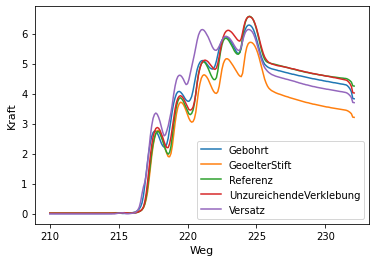

In [15]:
# %load src/preprocess/preprocess.py
import pandas as pd
import numpy as np
import hydra, prefect
from prefect import task

#TimeSeries
class PreprocessingClass_TimeSeries(PreprocessingBaseClass_TimeSeries):
    def __init__(self, config):
        self.file_path = config.preprocess_timeseries.file_path
        self.file_name = config.preprocess_timeseries.file_name
        self.file_sheet = config.preprocess_timeseries.file_sheet
        self.file_columns = config.preprocess_timeseries.file_columns
        self.file_columns_method = config.preprocess_timeseries.file_columns_method

        self.label =  config.preprocess_timeseries.label
        self.feature_encoding = config.preprocess_timeseries.feature_encoding.lower()
        self.label_encoding = config.preprocess_timeseries.label_encoding.lower()
        self.shuffle = config.preprocess_timeseries.shuffle
        self.train_split = config.preprocess_timeseries.split[0]
        self.val_split = config.preprocess_timeseries.split[1]
        self.test_split = config.preprocess_timeseries.split[2]

    def load_data(self):
        data = super().load_data(self.file_path, self.file_name, self.file_sheet)
        return data
    
    def cleaning_data(self, data):
        data = super().cleaning_data(data, self.file_columns, self.file_columns_method, self.label)
        return data

    def sklearn_normalization(self, data): 
        data = super().sklearn_normalization(data)
        return data

    def sklearn_standardization(self, data): 
        data = super().sklearn_standardization(data)
        return data
       
    def sklearn_onehot(self, data, inverse=False):
        data = super().sklearn_onehot(data)
        return data

    def sklearn_labelencoder(self, data):
        data = super().sklearn_labelencoder(data)
        return data

    def sklearn_split(self, data):
        x_train, y_train, x_test, y_test, x_val, y_val = super().sklearn_split(data, self.train_split, self.val_split, self.test_split, self.shuffle)
        return  x_train, y_train, x_test, y_test, x_val, y_val


def main_timeseries(cfg): 
    preprocess = PreprocessingClass_TimeSeries(cfg)
    #1. load data
    raw_data = preprocess.load_data()

    #2. clean data
    data = preprocess.cleaning_data(raw_data)

    #3. transform data (with sklearn split)
    #3.1 split in train/test/val
    x_train, y_train, x_val, y_val, x_test, y_test,  = preprocess.sklearn_split(data)

    #3.2 feature encoding (standardization or normalization or none)
    if preprocess.feature_encoding == "standardization":
        x_train = preprocess.sklearn_standardization(x_train)
        x_val = preprocess.sklearn_standardization(x_val)
        x_test = preprocess.sklearn_standardization(x_test)
    elif preprocess.feature_encoding == "normalization":
        x_train = preprocess.sklearn_normalization(x_train)
        x_val = preprocess.sklearn_normalization(x_val)
        x_test = preprocess.sklearn_normalization(x_test)   

    #3.3 label encoding (labelencoding string -> int, onehot or none)
    if preprocess.label_encoding == "labelencoding":
        y_train = preprocess.sklearn_labelencoder(y_train)
        y_val = preprocess.sklearn_labelencoder(y_val)    
        y_test = preprocess.sklearn_labelencoder(y_test)   
    elif preprocess.label_encoding == "onehot":
        y_train = preprocess.sklearn_onehot(y_train)
        y_val = preprocess.sklearn_onehot(y_val)
        y_test = preprocess.sklearn_onehot(y_test)

    print("x_train (some features):\n", x_train.describe())
    print("x_train (some features):\n", x_val.describe())
    print("x_train (some features):\n", x_test.describe())
    print("y_train (some targets):\n", y_train)

    #3.4 reshaping features (for fiting into 1D CNN)
    x_train = x_train.values.reshape(x_train.shape[0], x_train.shape[1], 1)
    x_val = x_val.values.reshape(x_val.shape[0], x_val.shape[1], 1)
    x_test = x_test.values.reshape(x_test.shape[0], x_test.shape[1], 1)

    
    ##############################ADDING PLOT FOR JUPYTER##############################
    unique, frequency = np.unique(data[preprocess.label], return_counts = True)
    print("Number classes:", len(unique), "\nName classes:", *unique)
 
    #Dataframe
    columns = [*unique]
    new_data = []
    for i in range(len(unique)):
        mean_data = (data.loc[data[preprocess.label] == columns[i]])
        mean_data = mean_data.mean()
        new_data.append(mean_data)
    new_data = pd.DataFrame(new_data).T
    new_data.columns = columns
    print(new_data)
    
    #Plot mean_Data
    new_data.plot()
    plt.xlabel("Weg", fontsize=11)
    plt.ylabel("Kraft", fontsize=11)
    plt.savefig("reports/Kurvenverlauf.svg", facecolor='white', edgecolor='white',bbox_inches='tight', orientation='portrait')
    
    #Korrelation Matrix
    print(new_data.corr())
    
    
if __name__ == "__main__":
    main_timeseries(cfg) #tested and worked

In [ ]:
#now plot will be saved in reports folder!